In [0]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# Initialize SparkSession (optional if already running in Databricks)
spark = SparkSession.builder.appName("DataAnalysis").getOrCreate()

# Query the Delta table from the catalog
df = spark.sql("SELECT * FROM final_project.default.global_health_statistics")

# Display the first few rows
df.show()

+------------+----+-------------------+----------------+-------------------+------------------+------------------+---------+------+-------------------+---------------------+----------------+----------------------+--------------+----------------------------+----------------------------------+-----------------+-----+--------------------------+-----------------------+---------------+---------------------+
|     Country|Year|       Disease Name|Disease Category|Prevalence Rate (%)|Incidence Rate (%)|Mortality Rate (%)|Age Group|Gender|Population Affected|Healthcare Access (%)|Doctors per 1000|Hospital Beds per 1000|Treatment Type|Average Treatment Cost (USD)|Availability of Vaccines/Treatment|Recovery Rate (%)|DALYs|Improvement in 5 Years (%)|Per Capita Income (USD)|Education Index|Urbanization Rate (%)|
+------------+----+-------------------+----------------+-------------------+------------------+------------------+---------+------+-------------------+---------------------+---------------

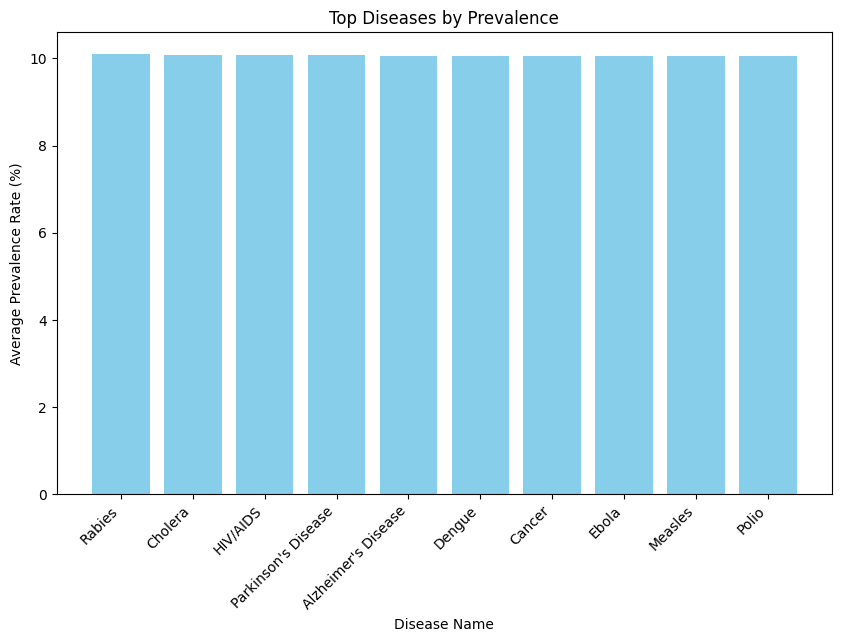

In [0]:
# Top diseases by prevalence
top_diseases = df.groupBy("Disease Name").agg(
    mean("Prevalence Rate (%)").alias("Avg Prevalence Rate")
).orderBy("Avg Prevalence Rate", ascending=False).limit(10).toPandas()

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(top_diseases["Disease Name"], top_diseases["Avg Prevalence Rate"], color='skyblue')
plt.xticks(rotation=45, ha="right")
plt.xlabel("Disease Name")
plt.ylabel("Average Prevalence Rate (%)")
plt.title("Top Diseases by Prevalence")
plt.show()


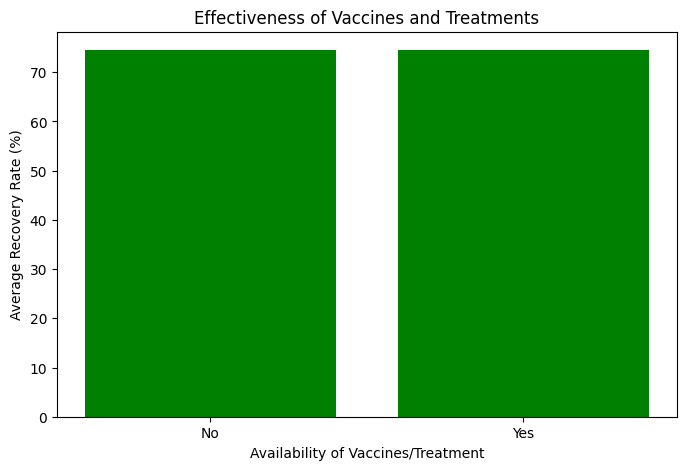

In [0]:
# Recovery rates by vaccine/treatment availability
vaccine_effectiveness = df.groupBy("Availability of Vaccines/Treatment").agg(
    mean("Recovery Rate (%)").alias("Avg Recovery Rate")
).toPandas()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(vaccine_effectiveness["Availability of Vaccines/Treatment"], vaccine_effectiveness["Avg Recovery Rate"], color='green')
plt.xlabel("Availability of Vaccines/Treatment")
plt.ylabel("Average Recovery Rate (%)")
plt.title("Effectiveness of Vaccines and Treatments")
plt.show()


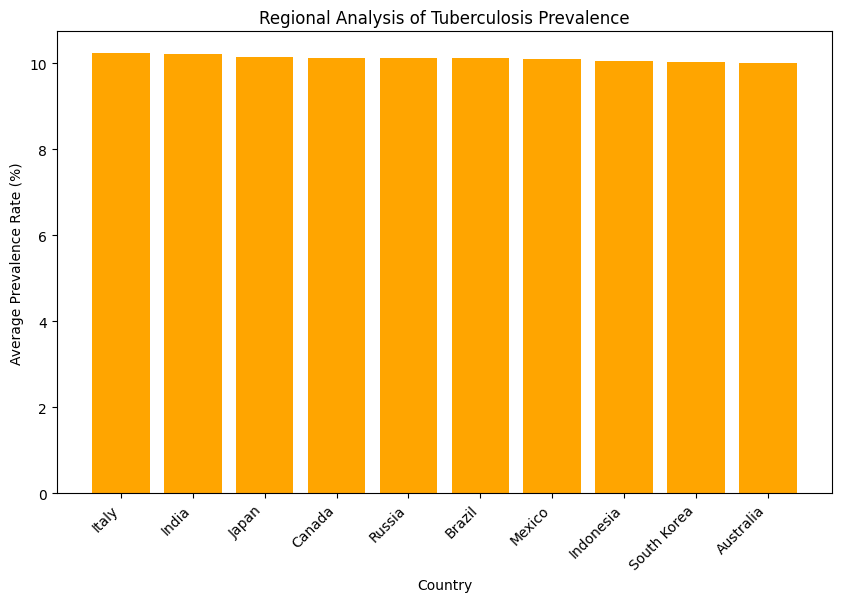

In [0]:
disease = "Tuberculosis"  # Replace with your disease of interest
regional_data = df.filter(df["Disease Name"] == disease).groupBy("Country").agg(
    mean("Prevalence Rate (%)").alias("Avg Prevalence Rate")
).orderBy("Avg Prevalence Rate", ascending=False).limit(10).toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(regional_data["Country"], regional_data["Avg Prevalence Rate"], color='orange')
plt.xticks(rotation=45, ha="right")
plt.xlabel("Country")
plt.ylabel("Average Prevalence Rate (%)")
plt.title(f"Regional Analysis of {disease} Prevalence")
plt.show()


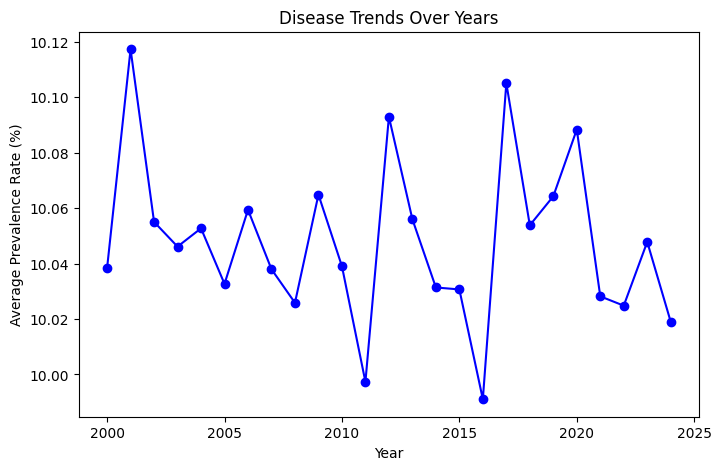

In [0]:
disease_trends = df.groupBy("Year").agg(
    mean("Prevalence Rate (%)").alias("Avg Prevalence Rate")
).orderBy("Year").toPandas()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(disease_trends["Year"], disease_trends["Avg Prevalence Rate"], marker='o', linestyle='-', color='blue')
plt.xlabel("Year")
plt.ylabel("Average Prevalence Rate (%)")
plt.title("Disease Trends Over Years")
plt.show()


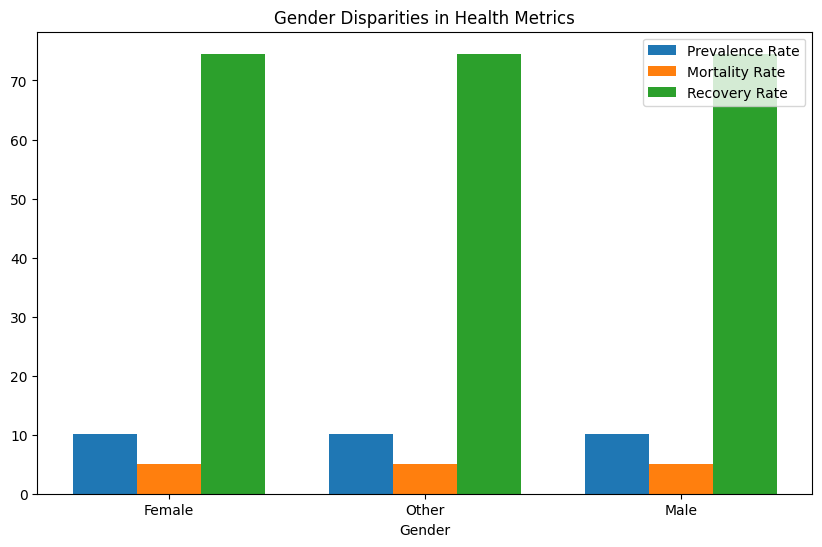

In [0]:
gender_data = df.groupBy("Gender").agg(
    mean("Prevalence Rate (%)").alias("Avg Prevalence Rate"),
    mean("Mortality Rate (%)").alias("Avg Mortality Rate"),
    mean("Recovery Rate (%)").alias("Avg Recovery Rate")
).toPandas()

# Plot
import numpy as np
gender_labels = gender_data["Gender"]
x = np.arange(len(gender_labels))  # Label locations
width = 0.25  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, gender_data["Avg Prevalence Rate"], width, label='Prevalence Rate')
ax.bar(x, gender_data["Avg Mortality Rate"], width, label='Mortality Rate')
ax.bar(x + width, gender_data["Avg Recovery Rate"], width, label='Recovery Rate')

ax.set_xlabel("Gender")
ax.set_title("Gender Disparities in Health Metrics")
ax.set_xticks(x)
ax.set_xticklabels(gender_labels)
ax.legend()
plt.show()


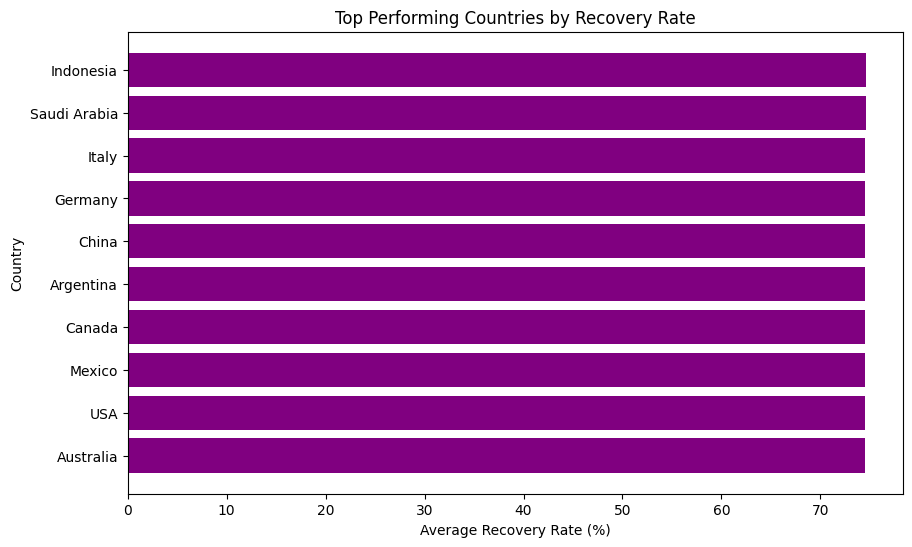

In [0]:
top_countries = df.groupBy("Country").agg(
    mean("Recovery Rate (%)").alias("Avg Recovery Rate")
).orderBy("Avg Recovery Rate", ascending=False).limit(10).toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_countries["Country"], top_countries["Avg Recovery Rate"], color='purple')
plt.xlabel("Average Recovery Rate (%)")
plt.ylabel("Country")
plt.title("Top Performing Countries by Recovery Rate")
plt.gca().invert_yaxis()  # Invert for descending order
plt.show()


/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


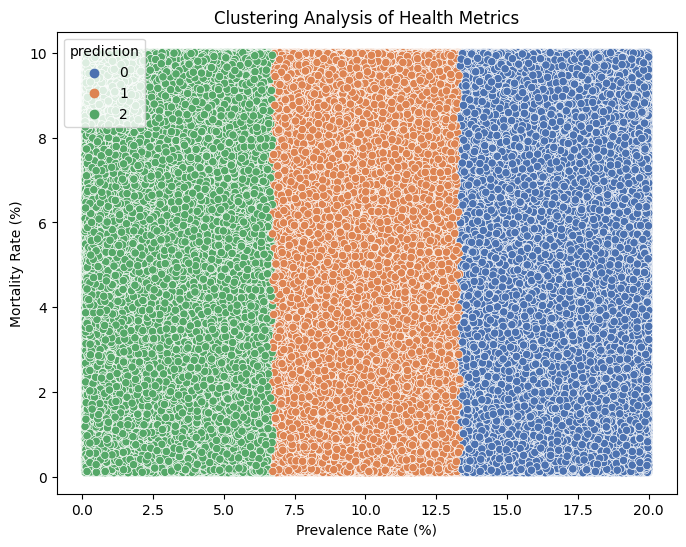

In [0]:
# Use features for clustering
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

assembler = VectorAssembler(inputCols=["Prevalence Rate (%)", "Mortality Rate (%)"], outputCol="features")
clustering_data = assembler.transform(df)

# Apply KMeans
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(clustering_data)
clusters = model.transform(clustering_data).select("Prevalence Rate (%)", "Mortality Rate (%)", "prediction").toPandas()

# Plot
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(data=clusters, x="Prevalence Rate (%)", y="Mortality Rate (%)", hue="prediction", palette="deep")
plt.title("Clustering Analysis of Health Metrics")
plt.show()
